# Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.engine.sequential import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import Model
from keras import metrics
import os
import functools
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import random
from sklearn.metrics import accuracy_score, recall_score
from keras.optimizers import Adam

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Constants

In [10]:
DATASET_PATH = "./Split_Dataset/"
image_length = 256

## Functions

In [12]:
# For Visualization of images and labels
def plot_images(image_array):
    num_images_per_row = 5
    num_images = len(image_array)
    num_rows = num_images // num_images_per_row
    if num_rows * 5 < num_images: num_rows += 1
    fig, axes = plt.subplots(num_rows, num_images_per_row)
    axes = axes.flatten()
    for img, ax in zip(image_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

LABELS = {0: "Carrying", 1: "Normal", 2: "Threat"}
def print_label(labels):
    if labels.shape == (3,):
        print(LABELS[np.where(labels == 1)[0][0]])
        return
    for label in labels:
        print(LABELS[np.where(label == 1)[0][0]])


In [13]:
def add_noise(filepath_or_image, noise_coefficient, noise_type = "pepper", seed = 4243):
    """Parameters:
    filepath_or_image: string, filepath of an image. OR, 2-Dimensional numpy array, image
    noise_coefficient: float, a number nc from 0 to 1. function will fill (nc*100)% of the image with noise
    noise_type = "pepper": string, "salt" or "pepper"
    seed = 1: int, set the random seed for the randomizer
    
    Function will output an image with (nc*100)% of noise specified."""
    if type(filepath_or_image) == str:
        image = cv2.imread(filepath_or_image)
    else:
        image = np.copy(filepath_or_image)
    image_dimensions = image.shape
    num_pixels = image_dimensions[0] * image_dimensions[1]
    random.seed(seed)
    noise = random.sample(range(0, num_pixels), int(num_pixels * noise_coefficient))
    noise_pixel_intensity = 255 if noise_type == "salt" else 0
    for pixel in noise:
        x = pixel // image_dimensions[1] # pixel position on the x-axis
        y = (pixel % image_dimensions[1]) - 1 # pixel position on the y-axis
        for i in [0, 1, 2]:
            image[x][y][i] = noise_pixel_intensity
    return image

def add_blur_default(image, ksize = (5,5), seed = 0):
    """Takes in an image and returns an image with blur. 
    ksize is the kernel size for the Gaussian Blur
    seed is for the generation of Standard Deviation used for Gaussian Blur. Default is 0
    Standard Deviation is normally distributed from the uniform distribution U(0,0.2)"""
    sd = random.uniform(0, 0.3)
    blurred = cv2.GaussianBlur(image, ksize, sd)
    return blurred

def add_noise_default(image, seed = 4243):
    """Takes in an image and returns an image with pepper noise. 
    Noise coefficient is randomly drawn from the uniform distribution, U(0, 0.2)
    Noise Type is randomly selected from salt or pepper"""
    noise_coefficient = random.uniform(0,0.2)
    noise_type = random.choice(["pepper", "salt"])
    img = add_noise(image, noise_coefficient, noise_type = noise_type, seed = seed)
    return img

def add_noise_and_blur_default(image, seed = 4243):
    """Takes in an image and returns an image with pepper noise. 
    Noise coefficient is randomly drawn from the uniform distribution, U(0, 0.2)
    Noise Type is randomly selected from salt or pepper"""
    noise_coefficient = random.uniform(0,0.2)
    noise_type = random.choice(["pepper", "salt"])
    img = add_blur_default(image)
    img = add_noise(img, noise_coefficient, noise_type = noise_type, seed = seed)
    return img

## Reading in Dataset to Flow

In [14]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
path = DATASET_PATH
train_path = path + "train/"
val_path = path + "val/"
test_path = path + "test/"
batch_size = 32
image_size = (image_length, image_length)

train_datagen = ImageDataGenerator(rescale =1./255, preprocessing_function=add_noise_and_blur_default,
                                   horizontal_flip = True,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 15,
                                   zoom_range = 0.1,
                                   fill_mode='reflect')
test_datagen = ImageDataGenerator(rescale = 1./255)


train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = 'rgb',
    shuffle = True,
)

validation_batches = test_datagen.flow_from_directory(
    val_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = 'rgb',
    shuffle = True,
)

test_batches = test_datagen.flow_from_directory(
    test_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = 'rgb',
    shuffle = True,
)

Found 4320 images belonging to 3 classes.
Found 540 images belonging to 3 classes.
Found 497 images belonging to 3 classes.


In [15]:
train_batches

In [16]:
images, labels = train_batches[0]

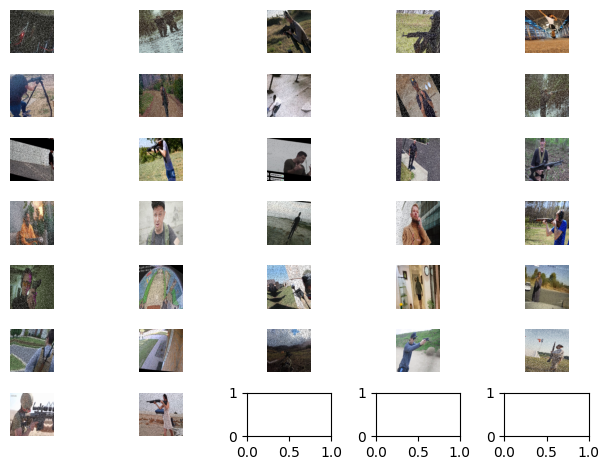

In [17]:
images
plot_images(images)
# print_label(labels)
# print(labels)

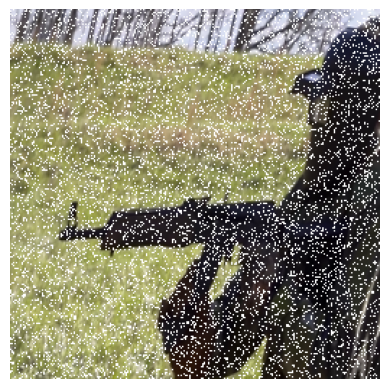

In [18]:
image_index = 3
plt.imshow(images[image_index])
plt.axis("off")
plt.show()

## Model

In [20]:
# Create a  model
def create_model(type = "Lenet-5"):
    model = keras.Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(image_length, image_length, 3)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')) # Added
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')) # Added
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')) # Added
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu')) # Changed from 120
    model.add(Dropout(0.2))

    model.add(Dense(units=3, activation = 'softmax'))


    return model

In [21]:
# Cell to start training
model = create_model()

# https://stackoverflow.com/questions/71799046/model-fit-gives-invalidargumenterror-graph-execution-error
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy', metrics.categorical_accuracy])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 average_pooling2d_4 (Averag  (None, 127, 127, 16)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 average_pooling2d_5 (Averag  (None, 62, 62, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 average_pooling2d_6 (Averag  (None, 30, 30, 32)      

In [33]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='lenet_enhanced_rgb_aug.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
        train_batches,
        steps_per_epoch = train_batches.__len__(),
        epochs = 20,
        workers = 8,
        validation_data = validation_batches,
        validation_steps = validation_batches.__len__(),
        shuffle = True,
        callbacks=my_callbacks
)


Epoch 1/20
135/135 [==============================] - 88s 639ms/step - loss: 0.6478 - accuracy: 0.7329 - categorical_accuracy: 0.7329 - val_loss: 0.6713 - val_accuracy: 0.7111 - val_categorical_accuracy: 0.7111
Epoch 2/20
135/135 [==============================] - 43s 300ms/step - loss: 0.6333 - accuracy: 0.7275 - categorical_accuracy: 0.7275 - val_loss: 0.6995 - val_accuracy: 0.7148 - val_categorical_accuracy: 0.7148
Epoch 3/20
135/135 [==============================] - 43s 303ms/step - loss: 0.6204 - accuracy: 0.7384 - categorical_accuracy: 0.7384 - val_loss: 0.6822 - val_accuracy: 0.7111 - val_categorical_accuracy: 0.7111
Epoch 4/20
135/135 [==============================] - 47s 334ms/step - loss: 0.6201 - accuracy: 0.7465 - categorical_accuracy: 0.7465 - val_loss: 0.6494 - val_accuracy: 0.7241 - val_categorical_accuracy: 0.7241
Epoch 5/20
135/135 [==============================] - 42s 294ms/step - loss: 0.6090 - accuracy: 0.7435 - categorical_accuracy: 0.7435 - val_loss: 0.6451 - v

## Testing

In [34]:
all_images = []
# Get y_test
y_test = []
for batch_num in range(test_batches.__len__()):
    images, labels = test_batches[batch_num]
    y_test.extend(labels)
    all_images.extend(images)
    
y_test = np.array(y_test)
y_tested_labels = [np.argmax(y_test[i]) for i in range(len(y_test))]

In [35]:
# Get y_prediction
y_prediction = model.predict(test_batches)

y_predicted_labels = [np.argmax(y_prediction[i]) for i in range(len(y_prediction))]

16/16 [==============================] - 16s 1s/step


In [36]:
print(y_tested_labels)
print(y_predicted_labels)

[0, 1, 0, 0, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 2, 0, 2, 0, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 1, 0, 2, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 

In [37]:
test_acc = accuracy_score(y_tested_labels, y_predicted_labels)

recall_macro =  recall_score(y_tested_labels, y_predicted_labels, average='macro')
recall_micro = recall_score(y_tested_labels, y_predicted_labels, average='micro')
recall_weighted = recall_score(y_tested_labels, y_predicted_labels, average='weighted')

print(f"test_acc: {test_acc}")
print(f"recall_macro: {recall_macro}")
print(f"recall_micro: {recall_micro}")
print(f"recall_weighted: {recall_weighted}")


test_acc: 0.7605633802816901
recall_macro: 0.760448769937821
recall_micro: 0.7605633802816901
recall_weighted: 0.7605633802816901


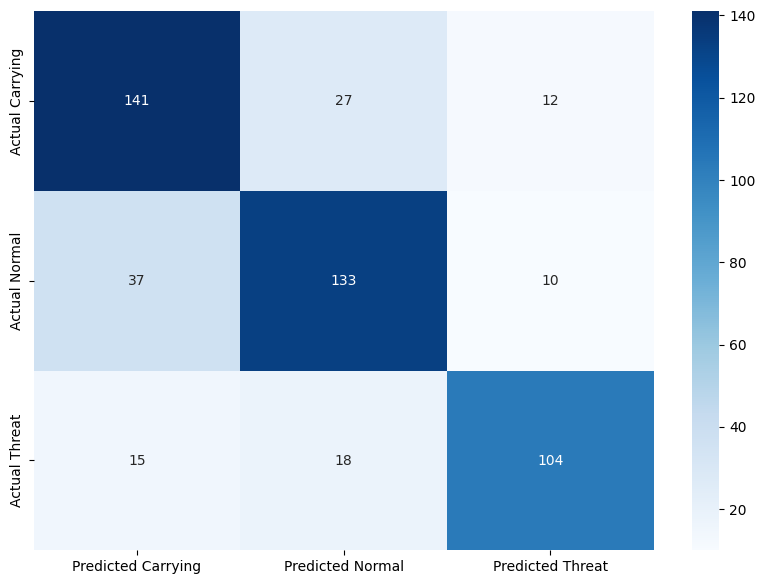

In [38]:
# Create confusion matrix
result = confusion_matrix(y_tested_labels, y_predicted_labels)
cf_matrix = pd.DataFrame(result, 
                                columns = ["Predicted Carrying", "Predicted Normal", "Predicted Threat"], 
                                index = ["Actual Carrying", "Actual Normal", "Actual Threat"])
plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, 
           annot=True, 
           cmap='Blues', 
           fmt='.3g')
plt.show()

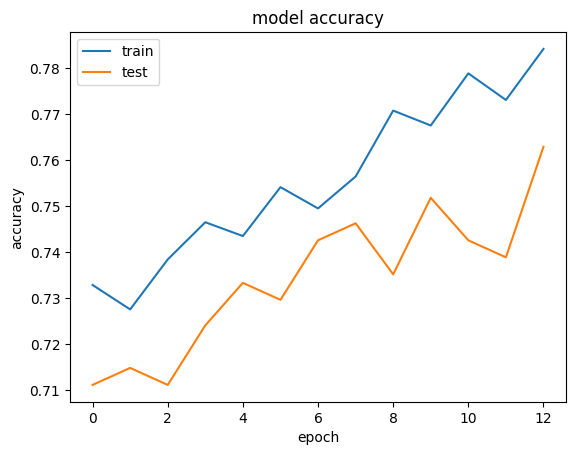

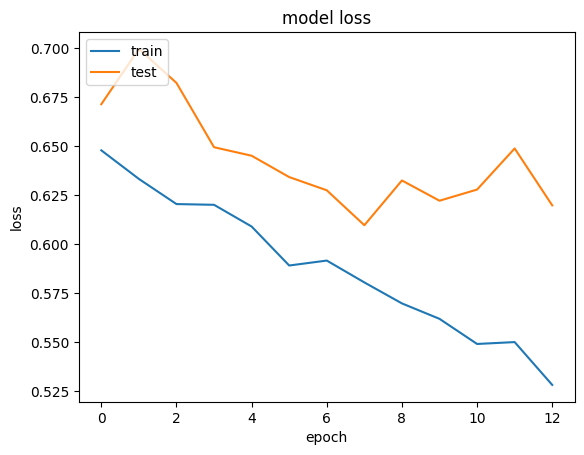

In [40]:
# summarize history for accuracy
history = history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()